In [1]:
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.preprocessing import normalize
from numpy.linalg import norm

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from gurobipy import Model, LinExpr, GRB, quicksum
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore")

import pickle

### Preliminary Algorithms

In [2]:
def subset_selection_Davis1(reward,utility,K,N):
    # r, u_i with len=N instead of N+1
    r = reward
    u_i = utility
    b = K           

    m = Model('Subset Selection')
    m.setParam('OutputFlag', 0) 

    w = list()      # probability of choosing {0} or items{1,...,N}
    for i in range(N+1):
        w.append(m.addVar(lb = 0, ub = 1, name = 'w_%i' % i))

    m.addConstr(quicksum(w[i] for i in range(1,N+1))+w[0], GRB.EQUAL, 1)
    m.addConstr(quicksum(w[i]/u_i[i-1] for i in range(1,N+1)) - b*w[0], GRB.LESS_EQUAL, 0)
    for i in range(1,N+1):
        m.addConstr(w[i]/u_i[i-1], GRB.GREATER_EQUAL, 0)
        m.addConstr(w[i]/u_i[i-1] - w[0], GRB.LESS_EQUAL, 0)

    m.setObjective(quicksum(w[i]*r[i-1] for i in range(1,N+1)), GRB.MAXIMIZE)

    m.update()            
    m.optimize()
    m.ObjVal
    x = m.getVars()

    items_offered = []
    for i in range(len(x)):
        if x[i].x>0:
            items_offered.append(x[i].varname)
    
    # items in the optimal assortment S_l, index start from 1!
    items_offered = [int(name[2:]) for name in items_offered]
    if items_offered[0]==0:
        items_offered = items_offered[1:]
    
    # check items_offered
    #print('check z: ',sum([r[i-1]*u_i[i-1]/(1+sum(u_i[i-1] for i in items_offered)) for i in items_offered]))
    return items_offered

### Baseline Algorithms
##### Fixed features - Alg2: TS-Beta,  Alg3: TS-Gaussian and Correlated Sampling¶

In [3]:
def AAGZ_Bern(N,T,K,r,v0,v):
    
# Initialize
    t = 1      
    l = 1  
    n_i = np.array([1 for i in range(N)])
    V_i = np.array([1 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward
    Optimal_R = 0
    regret_list = []


# Algorithm    
    while t<=T:
        # Posterior Sampling
        theta_i = np.array([np.random.beta(n_i[i],V_i[i]) for i in range(N)])
        u_i = 1/theta_i - 1

        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)

        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []
        
        # Optimal Reward
        optimal_items_offered = subset_selection_Davis1(r,v,K,N)
        optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
        optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])
        
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            if c != 0:
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += r[c-1]
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
            else: 
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += 0
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
                break
                
        epochs.append(t)

        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1
        l+=1
    return regret_list

In [4]:
def AAGZ_Gauss(N,T,K,r,v0,v):
    
# Initialize
    t = 0      
    l = 0  
    n_i = np.array([0 for i in range(N)])
    V_i = np.array([0 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward
    Optimal_R = 0
    regret_list = []
    
    vi_hat = np.array([0 for i in range(N)])  # vi_hat = Vi/ni
    
            
    optimal_items_offered = subset_selection_Davis1(r,v,K,N)
    optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
    optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])
        
    for i in range(1,N+1):
        display = [0,i]
        choice_p = [v0/(v0+v[i-1]), v[i-1]/(v0+v[i-1])]
        times_offeri = 0
        while True:
            choice_ = np.random.choice(a = display, p = choice_p)
            times_offeri += 1
            if choice_!= 0:
                """Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += r[choice_-1]
                re = Optimal_R - R
                regret_list.append(re)"""
                pass
            else:
                """Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += 0
                re = Optimal_R - R
                regret_list.append(re)"""
                break
        V_i[i-1] += times_offeri-1
        n_i[i-1] += 1
        t += times_offeri
        epochs.append(t)
        l += 1
        
# Algorithm    
    while t<=T:   
        # Update vi_hat
        vi_hat = V_i/n_i
        
        # Multiple Sampling: K samples of utility for each item i=1,...,N
        u_ij = np.array([[0.0 for j in range(K)] for i in range(N)])
        
        # Correlated Sampling
        for j in range(K):
            theta = np.random.normal(0,1)
            #u_ij[:,j] = vi_hat + theta*(np.sqrt(50*vi_hat*(vi_hat+1)/n_i) + 75*np.sqrt(np.log(T*K))/n_i)
            #the upper bound is too big
            u_ij[:,j] = vi_hat + theta*(np.sqrt(vi_hat*(vi_hat+1)/n_i) + np.sqrt(np.log(T*K))/n_i)
        
        u_i = np.max(u_ij, axis=1)
        u_i[np.where(u_i==0)] = 1e-9    # u_i is a divisor in subset_selection_Davis1() so it cannot be 0
        
        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)
        
        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []

        
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            if c != 0:
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += r[c-1]
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
            else: 
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += 0
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
                break
        epochs.append(t)
              
        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1

        l+=1
    
    return regret_list

##### Changing features - Alg2: TS-Beta,  Alg3: TS-Gaussian and Correlated Sampling¶

In [5]:
def AAGZ_Bern_withChangingProducts(N,T,K,v0,true_theta,RM_or_N):
    
# Initialize
    t = 1      
    l = 1  
    n_i = np.array([1 for i in range(N)])
    V_i = np.array([1 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward
    Optimal_R = 0
    regret_list = []
    
    rit = np.array([1 for i in range(N)])

    np.random.seed(800)
    true_theta = np.random.normal(0,1,D)
    Xit = contextual_setting(0,True)

    v = np.exp(np.dot(Xit,true_theta))
    
# Algorithm    
    while t<=T:
        if RM_or_N == 'RM':
            wp = np.random.rand()
            if wp < 0.5:
                pass
            elif wp > 0.75:
                Xit *= 1.05
            else:
                Xit /= 1.05
        else:
            Xit = contextual_setting(t,False)
        v = np.exp(np.dot(Xit,true_theta))
        
        # Posterior Sampling
        theta_i = np.array([np.random.beta(n_i[i],V_i[i]) for i in range(N)])
        u_i = 1/theta_i - 1

        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)

        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []
        
        optimal_items_offered = subset_selection_Davis1(r,v,K,N)
        optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
        optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])
        
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            
            if c != 0:
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += r[c-1]
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
            else: 
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += 0
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
                break
                
            
        epochs.append(t)

        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1
        l+=1

    return regret_list



def AAGZ_Gauss_withChangingProducts(N,T,K,v0,true_theta,RM_or_N):
    
# Initialize
    t = 0      
    l = 0  
    n_i = np.array([0 for i in range(N)])
    V_i = np.array([0 for i in range(N)]) 
    epochs = []         # times for each epoch
    R = 0               # Empirical Reward
    Optimal_R = 0
    regret_list = []

    rit = abs(np.random.normal(1,1,N))
    Xit = np.random.normal(0,1,size=(N,D))
    v = np.exp(np.dot(Xit,true_theta))
    
    vi_hat = np.array([0 for i in range(N)])  # vi_hat = Vi/ni
    
    for i in range(1,N+1):
        display = [0,i]
        choice_p = [v0/(v0+v[i-1]), v[i-1]/(v0+v[i-1])]
        times_offeri = 0
        while True:
            choice_ = np.random.choice(a = display, p = choice_p)
            times_offeri += 1
            if choice_!= 0:
                pass
            else:
                break
        V_i[i-1] += times_offeri-1
        n_i[i-1] += 1
        epochs.append(t)
        l += 1
                 
# Algorithm    
    while t<=T:   
        if RM_or_N == 'RM':
            wp = np.random.rand()
            if wp < 0.5:
                pass
            elif wp > 0.75:
                Xit *= 1.05
            else:
                Xit /= 1.05
        else:
            Xit = contextual_setting(t,False)
        v = np.exp(np.dot(Xit,true_theta))
        
        # Update vi_hat
        vi_hat = V_i/n_i
        
        # Multiple Sampling: K samples of utility for each item i=1,...,N
        u_ij = np.array([[0.0 for j in range(K)] for i in range(N)])
        
        # Correlated Sampling
        for j in range(K):
            theta = np.random.normal(0,1)
            u_ij[:,j] = vi_hat + theta*(np.sqrt(50*vi_hat*(vi_hat+1)/n_i) + 75*np.sqrt(np.log(T*K))/n_i)
        
        u_i = np.max(u_ij, axis=1)
        u_i[np.where(u_i==0)] = 1e-9    # u_i is a divisor in subset_selection_Davis1() so it cannot be 0
        
        # Subset Selection, inde start from 1!
        items_offered = subset_selection_Davis1(r, u_i, K, N)
        
        # Epoch-based offering
        ## add 0 (no purchase)
        items_list = np.insert(np.array(items_offered),0,0) 
        ## True choice probability
        v_l = np.array([v[i-1] for i in items_offered])
        choice_prob = v_l/(v0+sum(v_l))
        choice_prob_with0 = np.insert(choice_prob, 0, 1-sum(choice_prob))
        ## offer until no purchase
        c_l = []
        
        optimal_items_offered = subset_selection_Davis1(r,v,K,N)
        optimal_items_r = np.array([r[i-1] for i in optimal_items_offered])
        optimal_items_u = np.array([v[i-1] for i in optimal_items_offered])
           
        while True:
            c = np.random.choice(a = items_list, p = choice_prob_with0)
            if c != 0:
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += r[c-1]
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
            else: 
                Optimal_R += sum(optimal_items_r*optimal_items_u / (1+sum(optimal_items_u)))
                R += 0
                c_l.append(c)
                re = Optimal_R - R
                regret_list.append(re)
                t += 1
                break

        epochs.append(t)
              
        # Posterior updates
        items_picked, times_picked = np.unique(c_l[:-1], return_counts=True)
        for i in range(len(items_picked)):
            V_i[items_picked[i] -1] += times_picked[i]

        for i in items_offered:
            n_i[i-1] += 1
        l+=1
    
    return regret_list

In [6]:
def contextual_setting(t,fixed):
    
    if fixed:
        np.random.seed(800)

    else:
        np.random.seed(800+t)
    
    Xit = np.random.normal(0,1,size=(N,D-1))
    Xit = normalize(Xit, axis=1)
    Xit = np.append(Xit, [[1] for i in range(N)], axis=1)
    Xit = Xit/np.sqrt(2)

    return Xit

### Fixed Features

In [63]:
D = 10
N = 128
K = 8
T = 11000

rit = np.array([1 for i in range(N)])

np.random.seed(800)
true_theta = np.random.normal(0,1,D)
Xit = contextual_setting(0,True)
#print(true_theta,Xit)

r = rit
v0 = 1
v = np.exp(np.dot(Xit,true_theta))

regret_bern = []
for i in range(20):
    x = AAGZ_Bern(N,T,K,r,v0,v)
    regret_bern.append(x)
regret_bern = np.array([np.array(i[:10000]) for i in regret_bern])

regret_guass = []
for i in range(10):
    x = AAGZ_Gauss(N,T,K,r,v0,v)
    regret_guass.append(x)
regret_guass = np.array([np.array(i[:10000]) for i in regret_guass])

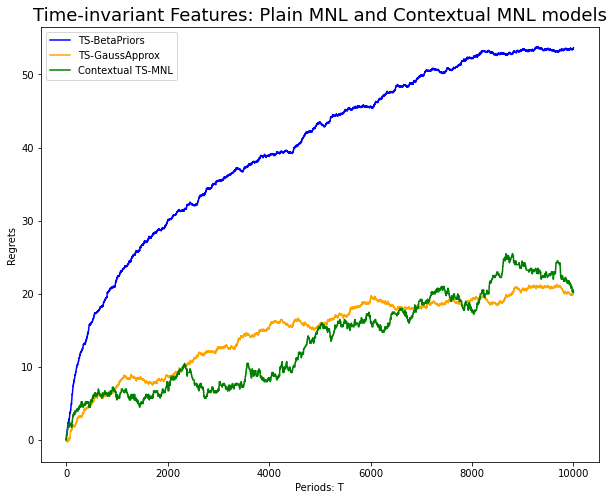

In [71]:
plt.figure(figsize=(10,8))
plt.plot(np.mean(regret_bern,axis=0), c="blue",label='TS-BetaPriors')
plt.plot(np.mean(regret_guass,axis=0), c="orange",label='TS-GaussApprox')
plt.plot(np.mean(x, axis=0), c="green",label='Contextual TS-MNL')
plt.title("Time-invariant Features: Plain MNL and Contextual MNL models", fontsize=18)
plt.legend()
plt.xlabel("Periods: T")
plt.ylabel("Regrets")
plt.show()

In [69]:
import pickle
import numpy as np
x=[]
for i in range(4):
    with open(f'TSMNL_regrets/TSMNL_regret_T10000_0823_Fixed{i}.pkl', 'rb') as f:
        x.append(pickle.load(f))

x = np.array([np.array(i) for i in x])



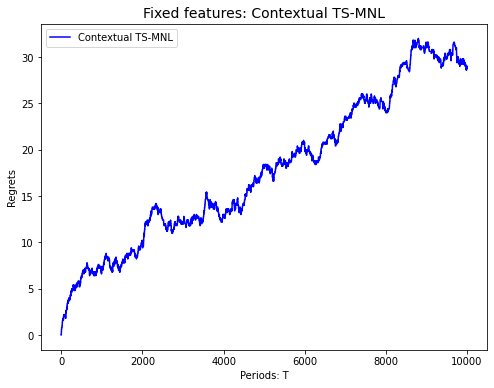

In [65]:
plt.figure(figsize=(8,6))
plt.plot(np.mean(x, axis=0), c="blue",label='Contextual TS-MNL')
plt.title("Fixed features: Contextual TS-MNL", fontsize=14)
plt.legend()
plt.xlabel("Periods: T")
plt.ylabel("Regrets")
plt.show()

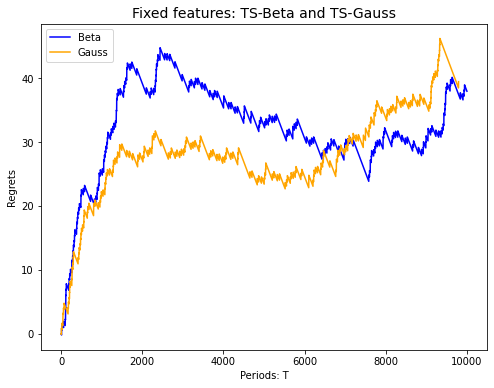

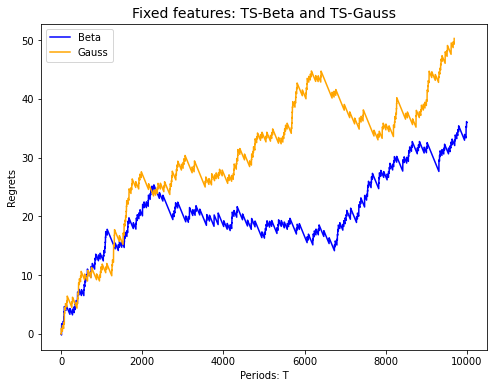

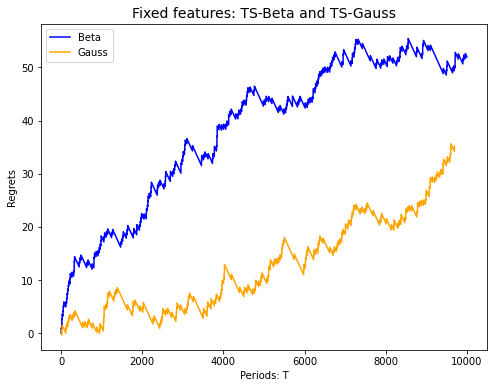

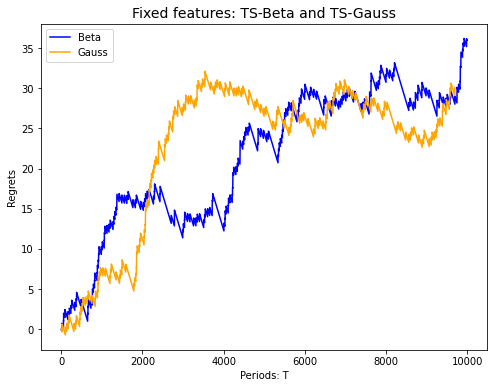

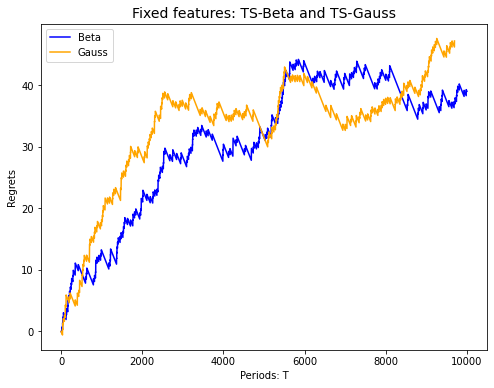

In [41]:
for i in range(5):
    plt.figure(figsize=(8,6))
    plt.plot(regret_bern[i], c="blue",label='Beta')
    plt.plot(regret_guass[i], c="orange",label='Gauss')
    plt.title("Fixed features: TS-Beta and TS-Gauss", fontsize=14)
    plt.legend()
    plt.xlabel("Periods: T")
    plt.ylabel("Regrets")
    plt.show()

### Changing Features

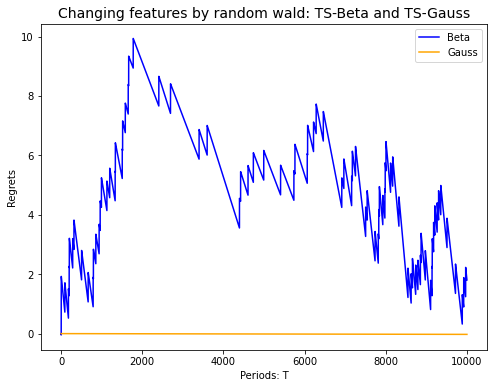

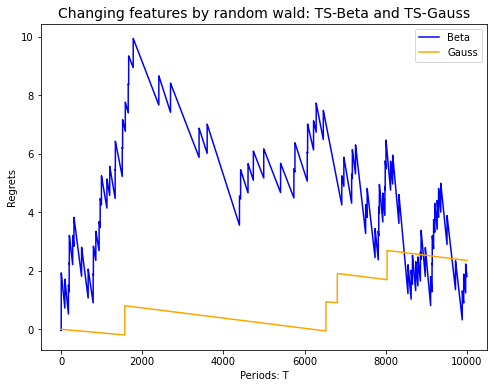

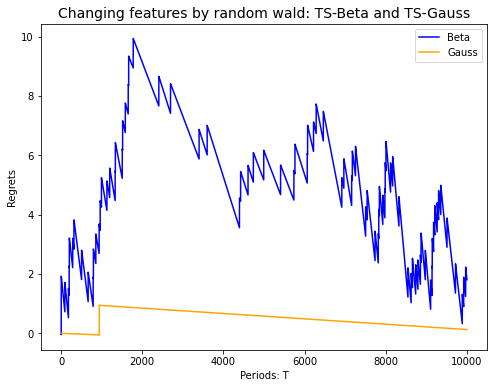

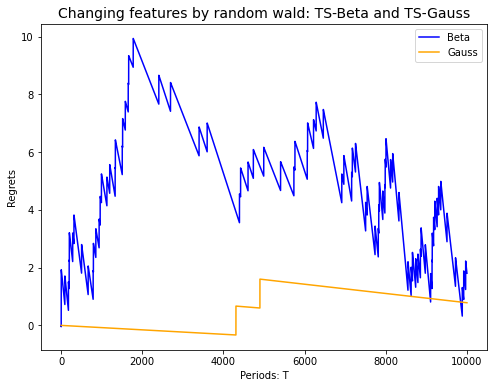

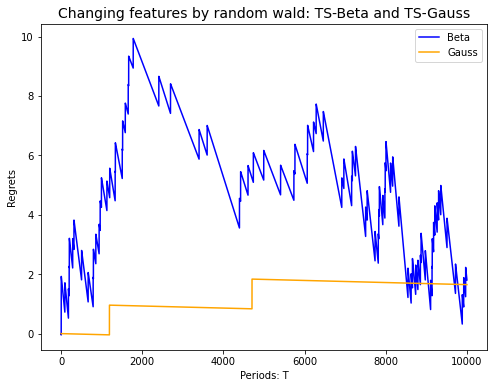

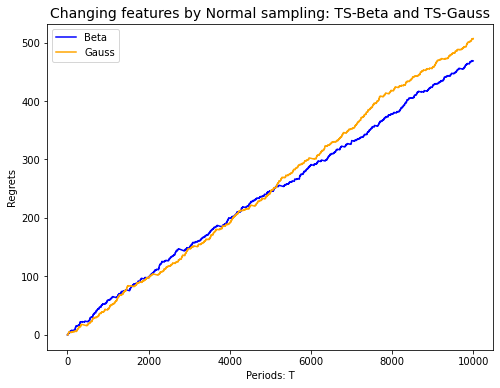

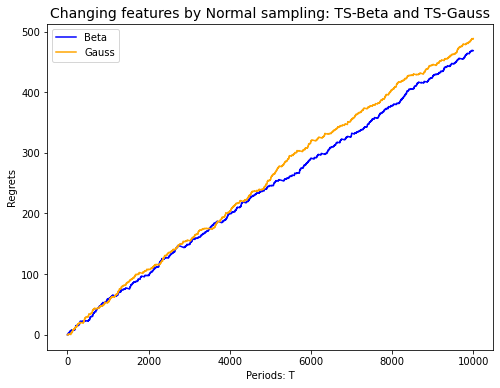

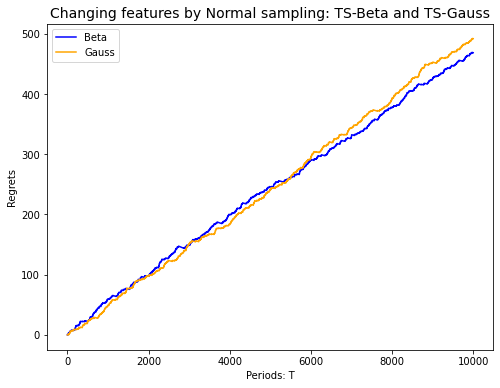

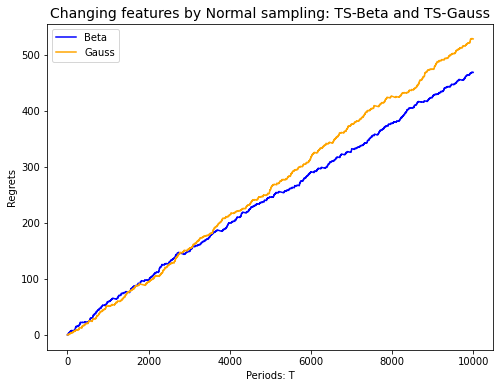

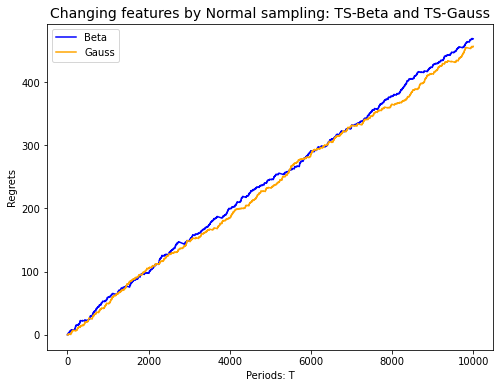

In [74]:
D = 10
N = 128
K = 8
T = 10000

rit = np.array([1 for i in range(N)])

np.random.seed(800)
true_theta = np.random.normal(0,1,D)
Xit = contextual_setting(0,True)
#print(true_theta,Xit)

r = rit
v0 = 1
v = np.exp(np.dot(Xit,true_theta))

regret_bern_RM = []
for i in range(5):
    x = AAGZ_Bern_withChangingProducts(N,T,K,v0,true_theta,'RM')
    regret_bern_RM.append(x)
regret_bern_RM = np.array([np.array(i[:T]) for i in regret_bern_RM])

regret_guass_RM = []
for i in range(5):
    x = AAGZ_Gauss_withChangingProducts(N,T,K,v0,true_theta,'RM')
    regret_guass_RM.append(x)
regret_guass_RM = np.array([np.array(i[:T]) for i in regret_guass_RM])

"""regret_bern_NN = []
for i in range(5):
    x = AAGZ_Bern_withChangingProducts(N,T,K,v0,true_theta,'NN')
    regret_bern_NN.append(x)
regret_bern_NN = np.array([np.array(i[:T]) for i in regret_bern_NN])

regret_guass_NN = []
for i in range(5):
    x = AAGZ_Gauss_withChangingProducts(N,T,K,v0,true_theta,'NN')
    regret_guass_NN.append(x)
regret_guass_NN = np.array([np.array(i[:T]) for i in regret_guass_NN])

"""
for i in range(5):
    plt.figure(figsize=(8,6))
    plt.plot(regret_bern_RM[i], c="blue",label='Beta')
    plt.plot(regret_guass_RM[i], c="orange",label='Gauss')
    plt.title("Changing features by random wald: TS-Beta and TS-Gauss", fontsize=14)
    plt.legend()
    plt.xlabel("Periods: T")
    plt.ylabel("Regrets")
    plt.show()

for i in range(5):
    plt.figure(figsize=(8,6))
    plt.plot(regret_bern_NN[i], c="blue",label='Beta')
    plt.plot(regret_guass_NN[i], c="orange",label='Gauss')
    plt.title("Changing features by Normal sampling: TS-Beta and TS-Gauss", fontsize=14)
    plt.legend()
    plt.xlabel("Periods: T")
    plt.ylabel("Regrets")
    plt.show()